In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import xtrack as xt
from pathlib import Path
import pandas as pd

from zoneinfo import ZoneInfo
from datetime import timedelta, datetime
import json
from matplotlib.lines import Line2D

# Files

In [2]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/abwlm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [3]:
df_params = pd.read_json('../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time
changes_ts = df_params.index.to_numpy()

df_fo = pd.read_json('../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

# Making new dict with paths per timestamp
paths_per_ts = {}
dt = timedelta(seconds=1)
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        if len(lll) > i:
            paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

# Classes and functions

In [4]:
class ABWLMBehavior(ak.Record):
    pass

class ABWLMCollectionBehavior(ak.Array):
    def cycle_stamp(self):
        return self['ABWLMSPS/Acquisition']['header']['cycleStamp'][0]
    
    def acq_done(self):
        return self['ABWLMSPS/Acquisition']['value']['acquisitionDone'][0]

    def bunch_intensities(self):
        return self['ABWLMSPS/Acquisition']['value']['bunchIntensities'][0][:,0]

    def bunch_lengths(self):
        return self['ABWLMSPS/Acquisition']['value']['bunchLengths'][0][:,0]

    def acq_time_from_inj(self):
        return self['ABWLMSPS/Acquisition']['value']['acqTimeFromInj'][0]
    
    def bucket_height(self):
        return self['ABWLMSPS/Acquisition']['value']['bucketHeight'][0][:,0]

ak.behavior["*", "ABWLMCollection"] = ABWLMCollectionBehavior

In [5]:
from datetime import datetime
import pandas as pd

def parse_timestamp_data(ts: str) -> datetime:
    """Convert 'YYYY.MM.DD.HH.MM.SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y.%m.%d.%H.%M.%S.%f")

def parse_timestamp_overview(ts: str) -> datetime:
    """Convert 'YYYY-MM-DD HH:MM:SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f")

def parse_any_timestamp(ts):
    """
    Parse a timestamp into a datetime.
    Supports:
      - int (nanoseconds since epoch)
      - overview strings (YYYY-MM-DD HH:MM:SS.microseconds)
      - data strings (YYYY.MM.DD.HH.MM.SS.microseconds)
      - already datetime
    """
    if isinstance(ts, int):  # nanoseconds since epoch
        return pd.to_datetime(ts, unit="ns").to_pydatetime()
    elif isinstance(ts, str):
        for parser in (parse_timestamp_overview, parse_timestamp_data):
            try:
                return parser(ts)
            except ValueError:
                continue
        # fallback: try without microseconds
        try:
            return datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            raise ValueError(f"Unrecognized timestamp format: {ts}")
    elif isinstance(ts, datetime):
        return ts
    else:
        raise TypeError("Timestamp must be int, str, or datetime")


In [6]:
def match_timestamps(meta_ts, data_ts_list, tolerance=pd.Timedelta("10s")):
    """
    Find the closest data timestamp to the given metadata timestamp.
    
    meta_ts        : str|int|datetime
    data_ts_list   : list of str|int|datetime
    tolerance      : maximum allowed difference (default: 10s)
    
    Returns: matching timestamp from data_ts_list or None if no match.
    """
    meta_dt = parse_any_timestamp(meta_ts)
    data_dts = [parse_any_timestamp(ts) for ts in data_ts_list]

    diffs = [abs((dt - meta_dt).total_seconds()) for dt in data_dts]
    min_idx = int(pd.Series(diffs).idxmin())

    if diffs[min_idx] <= tolerance.total_seconds():
        return data_ts_list[min_idx]
    return None

In [12]:
def get_radial_steering_val(acq_time, t_start=500, t_end=2984, max_dr=32e-3):
    acq_time = np.asarray(acq_time)  # works for scalar, list, or array
    a = max_dr / (t_end - t_start)
    # result = np.where(
    #     (acq_time < t_start) | (acq_time > t_end),
    #     0.0,
    #     a * (acq_time - t_start)
    # )
    result = np.where(
        (acq_time < t_start),
        0.0,
        a * (acq_time - t_start)
    )
    # return scalar if input was scalar
    return result.item() if result.shape == () else result


In [13]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
R = line.get_length()/(2*np.pi)
gamma_tr = 1/np.sqrt(line.twiss().momentum_compaction_factor)

def get_delta_shift(dR, gamma_tr=gamma_tr, R=R):
    return dR * gamma_tr**2 / R

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


# Data and metadata

In [7]:
with open(Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/full_overview.json')) as f:
    metadata = json.load(f)

In [8]:
data = {}
for p in paths_per_ts.path:
    ts = parse_timestamp_data(p.stem)
    data[ts] = ak.Array(ak.from_parquet(p), with_name="ABWLMCollection")

# Case 1

Positive radial steering, no tune shift, no bump, effect of chroma

"radial_steering": "DPpos",   
"bump": 0.0,   
"chroma": 0.5,   
"tune_shift": 0.0  

In [9]:
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.7 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 1.0 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}

In [10]:
ts_metadata = {0.5 : list(chroma_05.keys()), 0.7 : list(chroma_07.keys()), 1.0 : list(chroma_10.keys())}
data_ts = {}

for chroma in ts_metadata:
    data_ts[chroma] = []
    for ts in ts_metadata[chroma]:
        data_ts[chroma].append(match_timestamps(ts, list(data.keys())))

In [11]:
colours = {0.5: 'green', 0.7: 'orange', 1.0: 'red'}

## Intensity vs delta shift

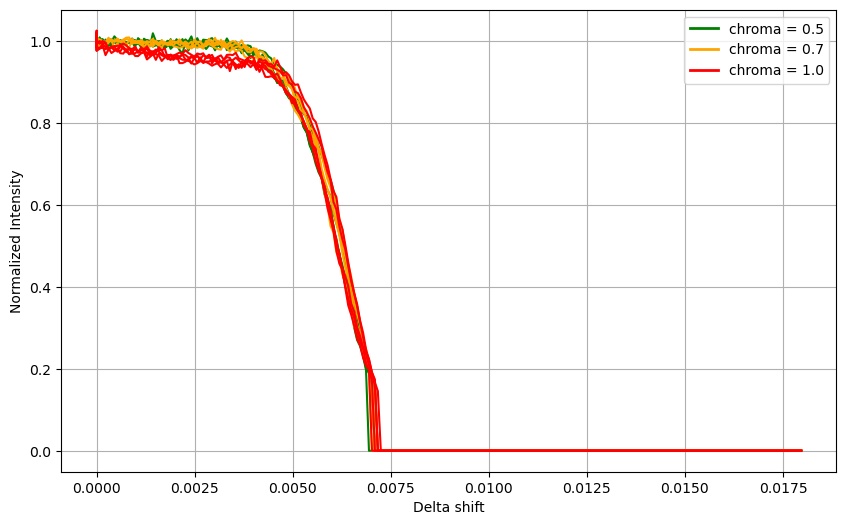

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Intensity vs bunch length

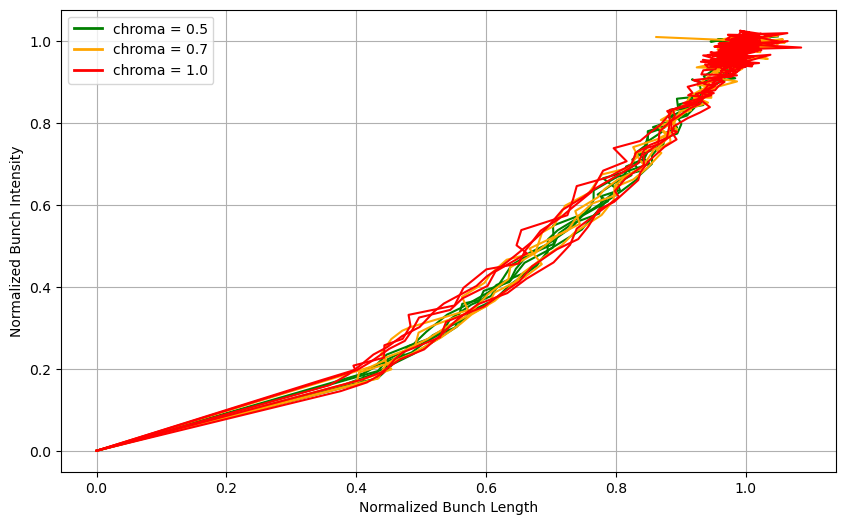

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Bunch length vs delta shift

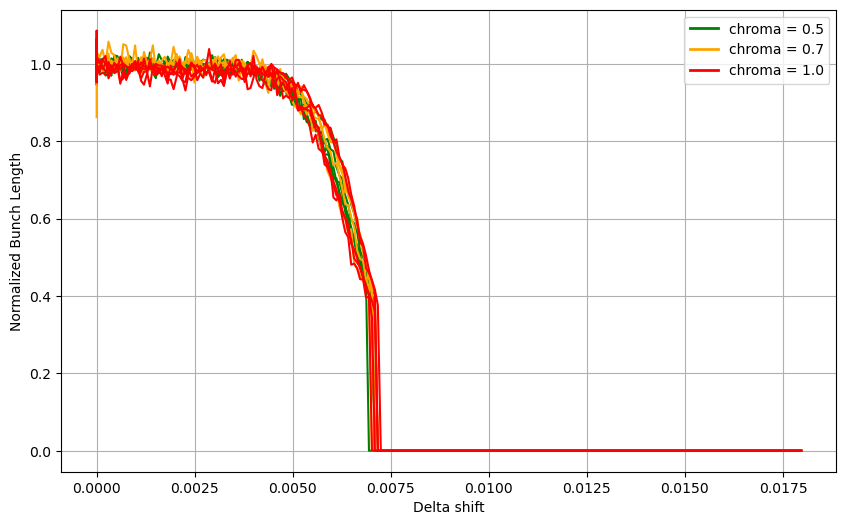

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Bucket

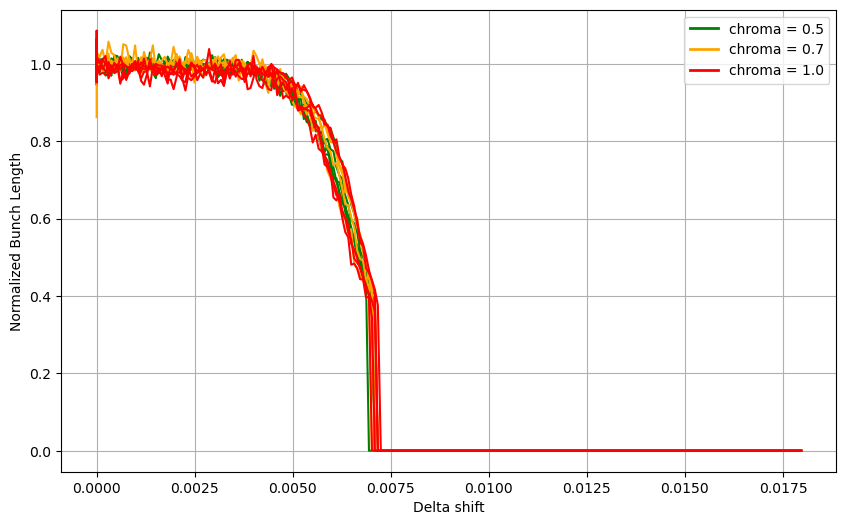

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

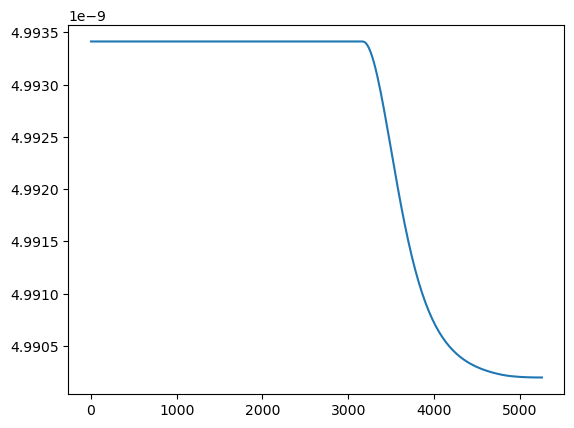

In [22]:
plt.plot(data[ts]['ABWLMSPS/Acquisition']['value']['acqTimeFromInj'][0], data[ts]['ABWLMSPS/Acquisition']['value']['bucketLength'][0])

bucket lenght for this cavity voltage (3MV) is 4.99e-09 s

In [29]:
inj_val_bl

np.float64(3.971158809198035e-09)

Bucket is filled up to 4/5

# Case 2


Positive radial steering, no tune shift, no bump, effect of chroma

"radial_steering": "DPpos",   
"bump": 0.0,   
"chroma": 0.5,   
"tune_shift": 0.0  

In [38]:
chroma_04 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.4 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.7 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 1.0 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}

In [43]:
ts_metadata = {0.4 : list(chroma_04.keys()), 0.5 : list(chroma_05.keys()), 0.7 : list(chroma_07.keys()), 1.0 : list(chroma_10.keys())}
data_ts = {}

for chroma in ts_metadata:
    data_ts[chroma] = []
    for ts in ts_metadata[chroma]:
        data_ts[chroma].append(match_timestamps(ts, list(data.keys())))

In [44]:
colours = {0.4 : 'blue', 0.5: 'green', 0.7: 'orange', 1.0: 'red'}

## Intensity vs delta shift

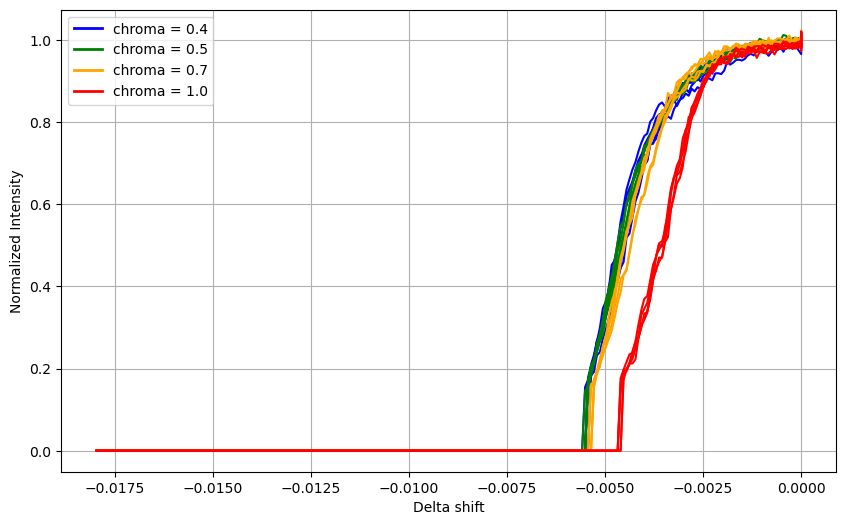

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Intensity vs bunch length

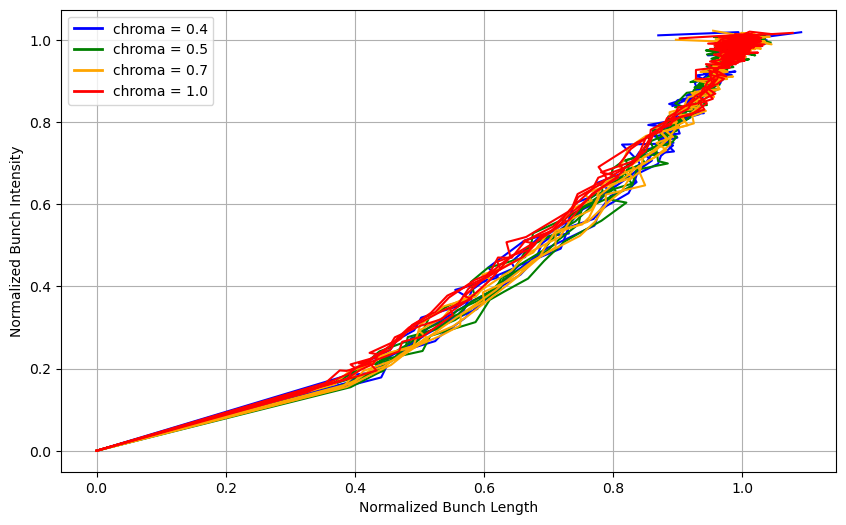

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Bunch length vs delta shift

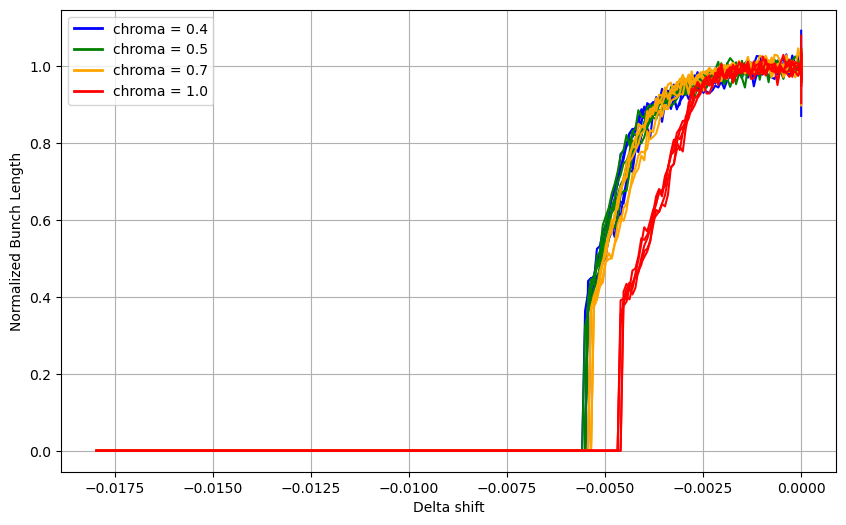

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

# Case 3

"radial_steering": "DPneg",  
"bump": 0.005,  
"chroma": 0.4 and 0.5,  
"tune_shift": 0.0

In [49]:
chroma_04_bump = {ts: params for ts, params in metadata.items() if params["bump"] == 0.005 and params["chroma"] == 0.4 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_05_bump = {ts: params for ts, params in metadata.items() if params["bump"] == 0.005 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}

chroma_04 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.4 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.7 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 1.0 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPneg"}

In [50]:
ts_metadata = {0.4 : list(chroma_04.keys()), 0.5 : list(chroma_05.keys()), 0.7 : list(chroma_07.keys()), 1.0 : list(chroma_10.keys())}
ts_metadata_bump = {0.4 : list(chroma_04_bump.keys()), 0.5 : list(chroma_05_bump.keys())}
data_ts = {}
data_ts_bump = {}

for chroma in ts_metadata:
    data_ts[chroma] = []
    for ts in ts_metadata[chroma]:
        data_ts[chroma].append(match_timestamps(ts, list(data.keys())))

for chroma in ts_metadata_bump:
    data_ts_bump[chroma] = []
    for ts in ts_metadata_bump[chroma]:
        data_ts_bump[chroma].append(match_timestamps(ts, list(data.keys())))

In [51]:
colours = {0.4 : 'blue', 0.5: 'green', 0.7: 'orange', 1.0: 'red'}
colours_bump = {0.4 : 'cyan', 0.5: 'lime'}

## Intensity vs delta shift

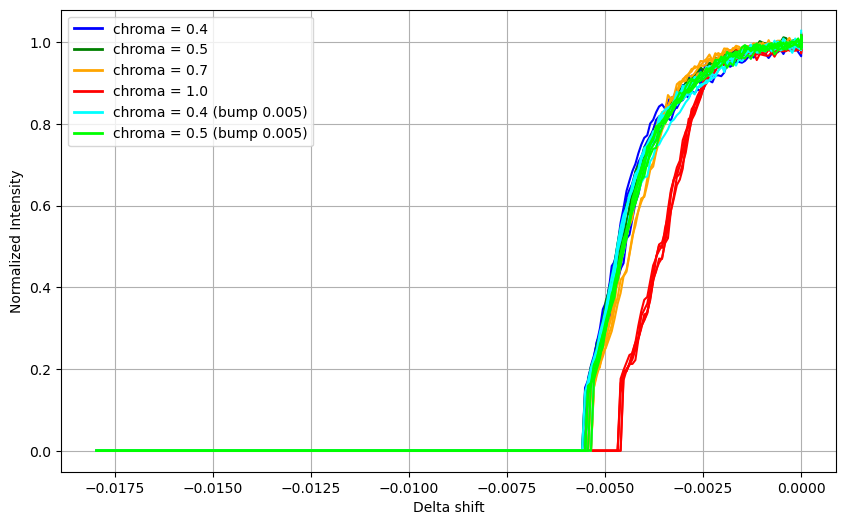

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

for chroma in data_ts_bump:
    for ts in data_ts_bump[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours_bump[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
    Line2D([0], [0], color='cyan', lw=2, label='chroma = 0.4 (bump 0.005)'),
    Line2D([0], [0], color='lime', lw=2, label='chroma = 0.5 (bump 0.005)'),
]
ax.legend(handles=legend_elements)

## Intensity vs bunch length

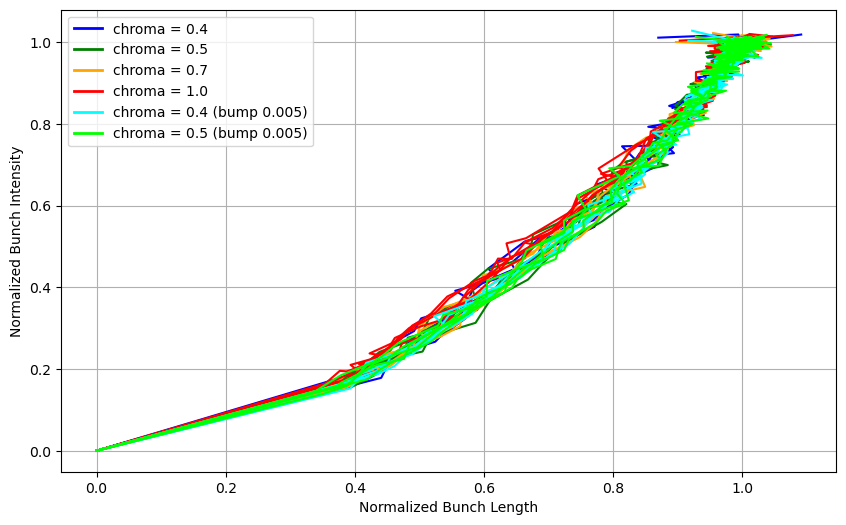

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

for chroma in data_ts_bump:
    for ts in data_ts_bump[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours_bump[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
    Line2D([0], [0], color='cyan', lw=2, label='chroma = 0.4 (bump 0.005)'),
    Line2D([0], [0], color='lime', lw=2, label='chroma = 0.5 (bump 0.005)'),
]
ax.legend(handles=legend_elements)

## Bunch length vs delta shift

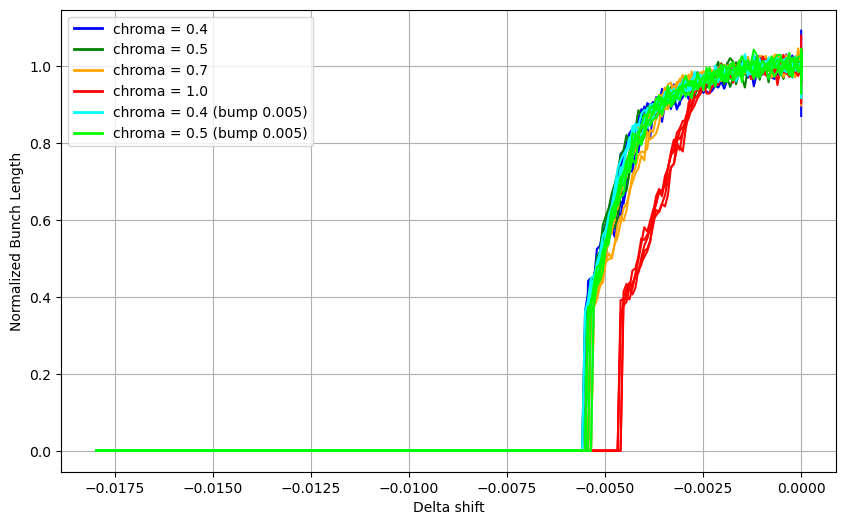

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

for chroma in data_ts_bump:
    for ts in data_ts_bump[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours_bump[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='chroma = 0.4'),
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
    Line2D([0], [0], color='cyan', lw=2, label='chroma = 0.4 (bump 0.005)'),
    Line2D([0], [0], color='lime', lw=2, label='chroma = 0.5 (bump 0.005)'),
]
ax.legend(handles=legend_elements)

# Case 3
"radial_steering": "DPneg",  
"bump": 0.01,  
"chroma": 0.5, 0.6, 0.7, 1.0  
"tune_shift": 0.05  

In [55]:
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_06 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.6 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.7 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 1.0 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}

In [56]:
ts_metadata = {0.5 : list(chroma_05.keys()), 0.6 : list(chroma_06.keys()), 0.7 : list(chroma_07.keys()), 1.0 : list(chroma_10.keys())}
data_ts = {}

for chroma in ts_metadata:
    data_ts[chroma] = []
    for ts in ts_metadata[chroma]:
        data_ts[chroma].append(match_timestamps(ts, list(data.keys())))

In [57]:
colours = {0.5: 'green', 0.6: 'gold', 0.7: 'orange', 1.0: 'red'}

## Intensity vs delta shift

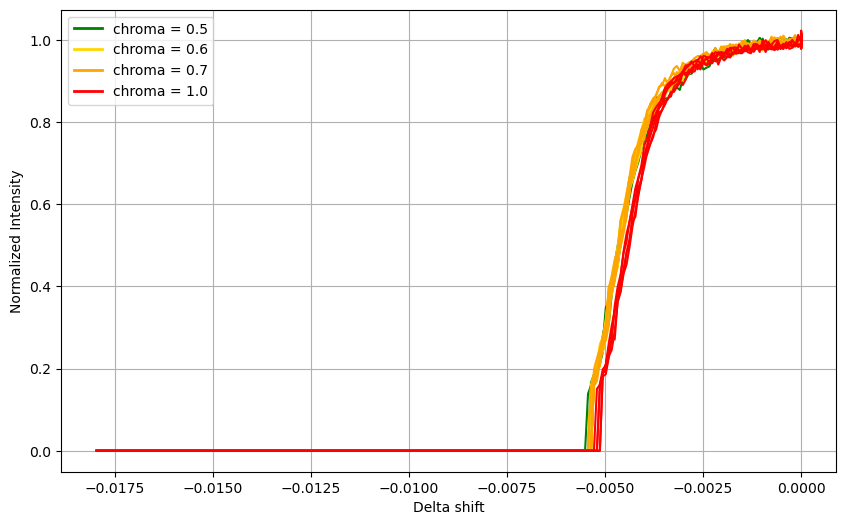

In [59]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='gold', lw=2, label='chroma = 0.6'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Intensity vs bunch length

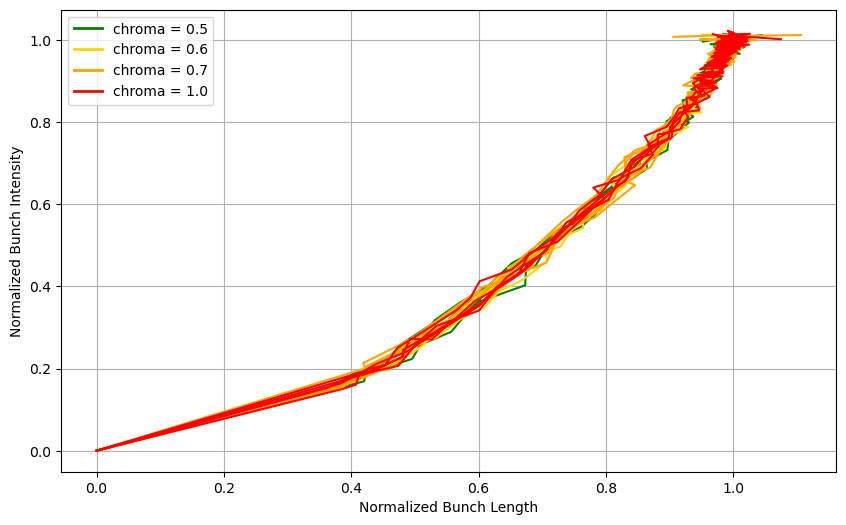

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='gold', lw=2, label='chroma = 0.6'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Bunch length vs delta shift

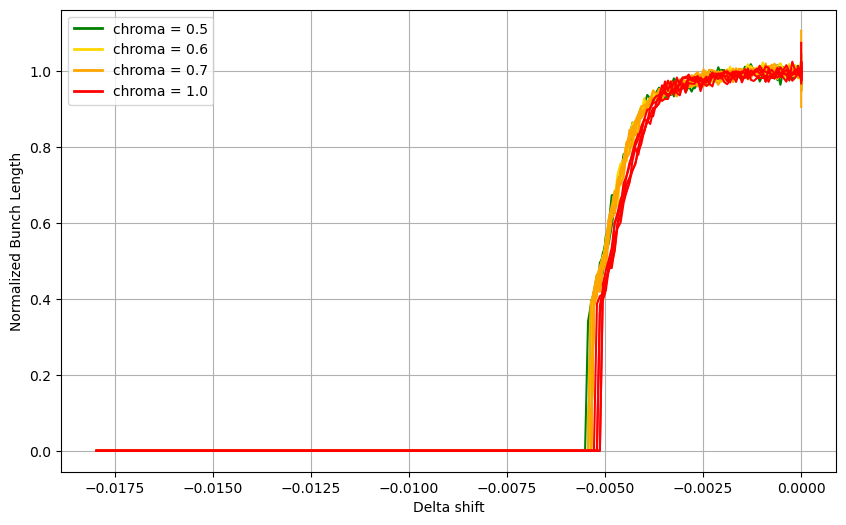

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='gold', lw=2, label='chroma = 0.6'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

# Case 5 - Other radial steering, bumping towards tidp
"radial_steering": "DPneg",  
"bump": 0.0, -0.01, -0.011, -0.012, -0.013, -0.014, -0.015, -0.016, -0.017, -0.018, -0.019, -0.02,  
"chroma": 0.5,  
"tune_shift": 0.05,  

In [ ]:
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_06 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.6 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 0.7 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.01 and params["chroma"] == 1.0 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}

In [62]:
bump0 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m10 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.01 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m11 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.011 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m12 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.012 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m13 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.013 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m14 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.014 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m15 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.015 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m16 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.016 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m17 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.017 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m18 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.018 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m19 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.019 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}
bump_m20 = {ts: params for ts, params in metadata.items() if params["bump"] == -0.020 and params["chroma"] == 0.5 and params["tune_shift"] == 0.05 and params["radial_steering"] == "DPneg"}

In [76]:
ts_metadata = {0.0 : list(bump0.keys()), -0.01 : list(bump_m10.keys()), -0.011 : list(bump_m11.keys()), -0.012 : list(bump_m12.keys()), -0.013 : list(bump_m13.keys()), -0.014 : list(bump_m14.keys()), -0.015 : list(bump_m15.keys()), -0.016 : list(bump_m16.keys()), -0.017 : list(bump_m17.keys()), -0.018 : list(bump_m18.keys()), -0.019 : list(bump_m19.keys()), -0.020 : list(bump_m20.keys())}
data_ts = {}

for bump in ts_metadata:
    data_ts[bump] = []
    for ts in ts_metadata[bump]:
        data_ts[bump].append(match_timestamps(ts, list(data.keys())))

In [77]:
data_ts.keys()

dict_keys([0.0, -0.01, -0.011, -0.012, -0.013, -0.014, -0.015, -0.016, -0.017, -0.018, -0.019, -0.02])

In [78]:
bump_vals = [-0.01, -0.011, -0.012, -0.013, -0.014, -0.015,
             -0.016, -0.017, -0.018, -0.019, -0.02]

# normalize values to [0, 1] for colormap
norm = plt.Normalize(vmin=min(bump_vals), vmax=max(bump_vals))
cmap = plt.cm.plasma

colours = {bump: cmap(norm(bump)) for bump in bump_vals}
colours[0.0] = 'green'

## Intensity vs delta shift

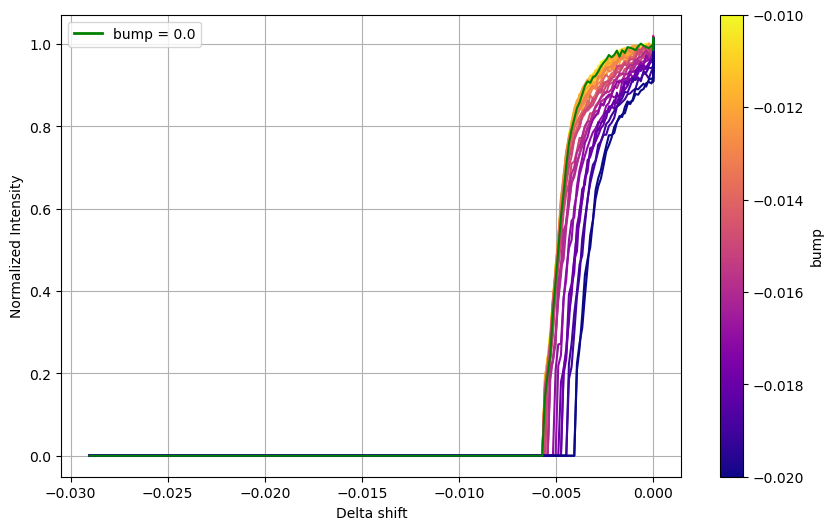

In [92]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for bump in data_ts:
    if bump != 0.0:
        for ts in data_ts[bump]:
            if ts is not None:
                idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
                inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

                dr = get_radial_steering_val(data[ts].acq_time_from_inj(), t_start=1027, t_end=1967, max_dr=-22e-3)
                delta_shift = get_delta_shift(dr)
                ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

bump = 0.0
for ts in data_ts[bump]:
    if ts is not None:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), t_start=1027, t_end=1967, max_dr=-22e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='bump = 0.0'),
]

ax.legend(handles=legend_elements)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label="bump")

## Intensity vs bunch length

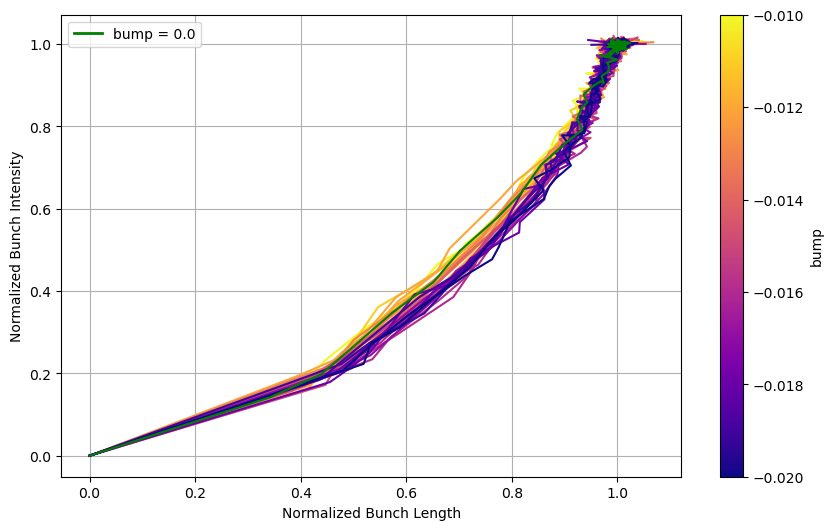

In [93]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for bump in data_ts:
    if bump != 0.0:
        for ts in data_ts[bump]:
            if ts is not None:
                idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
                inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
                inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

                dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
                delta_shift = get_delta_shift(dr)
                ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

bump = 0.0
for ts in data_ts[bump]:
            if ts is not None:
                idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
                inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
                inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

                dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
                delta_shift = get_delta_shift(dr)
                ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='bump = 0.0'),
]

ax.legend(handles=legend_elements)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label="bump")

## Bunch length vs delta shift

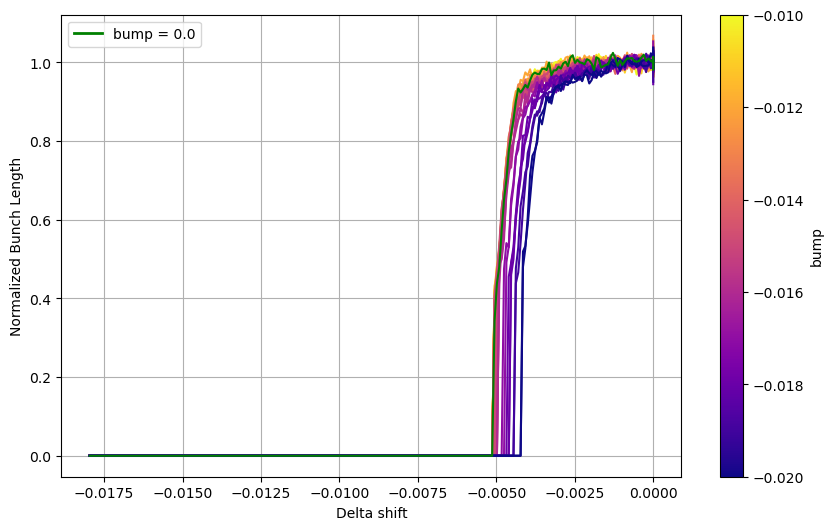

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for bump in data_ts:
    if bump != 0.0:
        for ts in data_ts[bump]:
            if ts is not None:
                idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
                inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

                dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
                delta_shift = get_delta_shift(dr)
                ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
bump = 0.0
for ts in data_ts[bump]:
    if ts is not None:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj(), max_dr=-32e-3)
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[bump], label=ts.strftime("%Y-%m-%d %H:%M:%S"))

ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='bump = 0.0'),
]

ax.legend(handles=legend_elements)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label="bump")